In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# constants
c_m = 1e-6 # 1 uF/cm^2
r_m = 25e3 # 25 kOhm*cm^2, taken from Egger et al 2020
v_rest = -0.065 # V
v_thresh = -0.050 # V
soma_radius = 0.003 # cm (30 um), upscaled to account for dendrites
soma_area = 4 * np.pi * soma_radius**2 # cm^2
g_leak = 1 / (r_m / soma_area) # S
soma_c = c_m * soma_area # F   
tau_m = c_m * r_m # sec
r_m / (soma_area)


221048532.07207686

In [3]:
sim_time = 0.4 # sec
dt = 0.001 # sec
step_num = int(sim_time / dt)
inp = np.zeros(step_num)
inp[100:200] = -1e-11 
v_m= np.zeros(step_num)
v_m[0] = v_rest
i_m = np.zeros(step_num)
t = (np.arange(0, inp.size) * dt)* 1000 # ms
spk = False
for i in range(1, len(inp)):

    i_m[i] = (g_leak * (v_m[i-1] - v_rest)) + inp[i]

    if (v_m[i-1] > v_thresh) & (spk == False):
        i_m[i] = i_m[i] - 1e-9
        spk = True
    elif spk == True:
        spk = False
        v_m[i] = v_rest - 0.01
        continue

    v_m[i] = v_m[i-1] + -(i_m[i] / soma_c) * dt

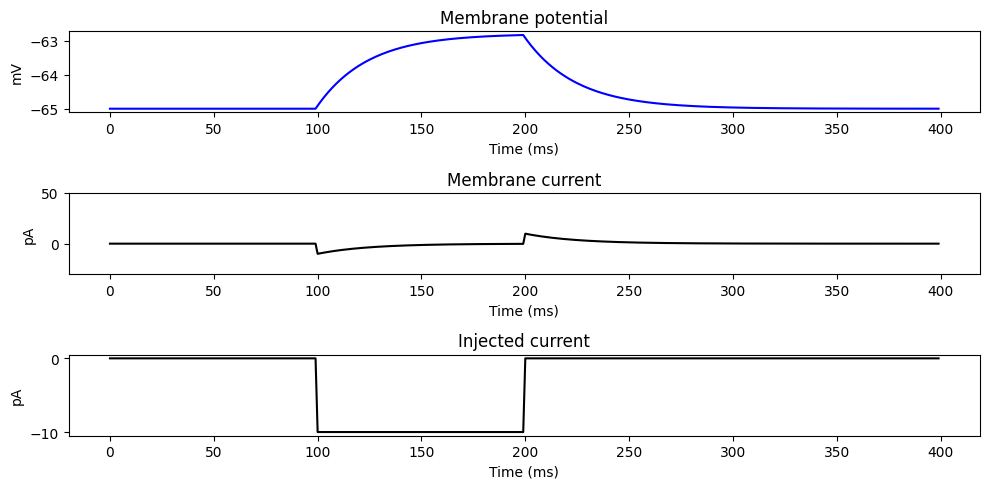

In [4]:
# plot v_m and inp on the same axis with separate y-axes
fig, ax = plt.subplots(3,1,figsize=(10,5))
ax[0].plot(t, v_m*1000, 'b')
ax[0].set_title('Membrane potential')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('mV')

ax[1].plot(t, i_m*10**12, 'k')
ax[1].set_ylim((-30, 50))
ax[1].set_title('Membrane current')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('pA')

ax[2].plot(t, inp*10**12, 'k')
ax[2].set_title('Injected current')
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('pA')

fig.tight_layout()

In [74]:
class Neuron:
    def __init__(self, v_rest=-65, c_m=1, r_m=25, radius=30, dt=0.0001):
        self.dt = dt # sec
        self._vrest = v_rest/1000 # mV
        self._cm = c_m * 1e-6 # uF/cm^2
        self._rm = r_m * 1e3 # kOhm*cm^2
        self._radius = radius * 1e-4 # cm

        self._area = 4 * np.pi * self._radius**2 # cm^2
        self._c = self._cm * self._area # F  
        self._gleak = 1 / (self._rm / self._area) # S

        self._vm = self._vrest
        self._im = 0
        self._inp = 0

    def get_tau(self):
        return self._cm * self._rm
    
    def set_input(self, inp=0):
        self._inp = inp
    
    def reset_state(self):
        self._vm = self._vrest
        self._im = 0
        self._inp = 0
    
    def get_state(self):
        # return membrane potential in mV, membrane current in pA, and spike status
        return self._vm*1e3, self._im*1e12
        
    def update(self):
        # solve for transmembrane currents
        self._im = (self._gleak * (self._vm - self._vrest)) + self._inp
        
        # update membrane potential
        self._vm = self._vm + -(self._im / self._c) * self.dt
        
    def run_step(self, inp=0):
        self.set_input(inp)
        self.update()
        return self.get_state()

In [104]:
sim_time = 0.4 # sec
dt = 0.0001 # sec
step_num = int(sim_time / dt)
t_pts = np.arange(0, step_num) * dt * 1000 # ms
inp_levels = -np.arange(-4e-11, 1.1e-10, 2e-11)
lvl_num = inp_levels.size
inp = np.zeros((step_num, lvl_num))
inp[1000:2000,:] = 1
inp = inp * inp_levels
nrn1 = Neuron(radius=30)
v_m1 = np.zeros(inp.shape)
i_m1 = np.zeros(inp.shape)
for i in range(inp.shape[1]):
    nrn1.reset_state()
    for t in range(inp.shape[0]):
        v_m1[t,i], i_m1[t,i] = nrn1.run_step(inp[t,i])

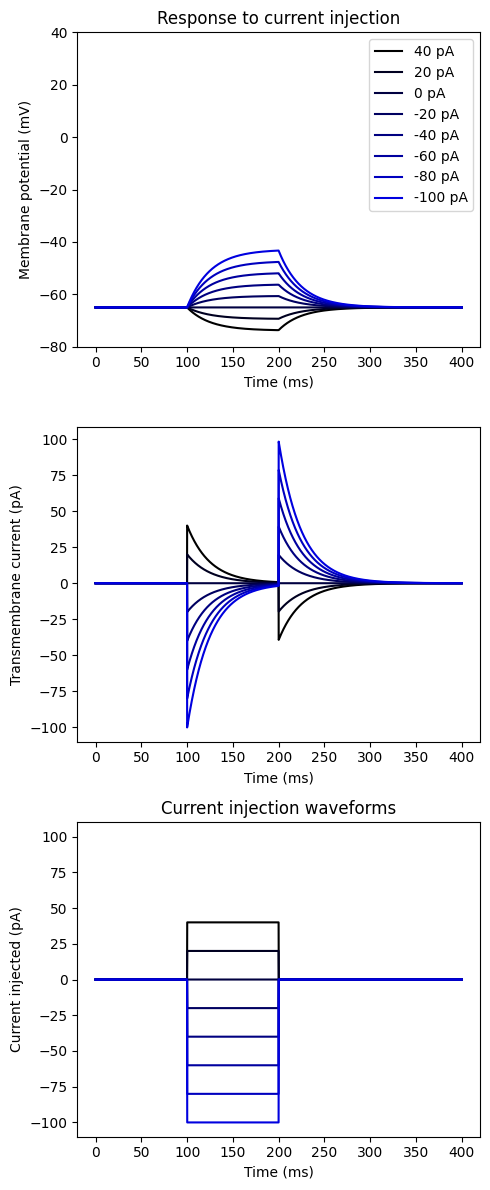

In [105]:
fig, ax = plt.subplots(3,1,figsize=(5,12))
for ind, lvl in enumerate(inp_levels):
    ax[0].plot(t_pts,v_m1[:,ind], label=str(round(lvl*1e12))+' pA', color=[0,0,ind/inp_levels.size])
    ax[1].plot(t_pts,i_m1[:,ind], label=str(round(lvl*1e12))+' pA', color=[0,0,ind/inp_levels.size])
    ax[2].plot(t_pts,inp[:,ind]*1e12, label=str(round(lvl*1e12))+' pA', color=[0,0,ind/inp_levels.size])

ax[0].set_title('Response to current injection')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Membrane potential (mV)')
ax[0].set_ylim((-80, 40))
ax[0].legend()

ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Transmembrane current (pA)')

ax[2].set_title('Current injection waveforms')
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Current injected (pA)')
ax[2].set_ylim((-110, 110))
fig.tight_layout()
plt.show()

In [113]:
# create spiking neuron class inheriting from Neuron
class SpikingNeuron(Neuron):
    def __init__(self, v_rest=-65, c_m=1, r_m=25, radius=30, v_thresh=-50, e_na=50, e_k=-90, dt=0.0001):
        super().__init__(v_rest, c_m, r_m, radius, dt)
        self._vthresh = v_thresh / 1000 # mV
        self._ena = e_na / 1000 # mV
        self._gna = 8e-8 # S
        self._ek = e_k / 1000 # mV
        self._gk = 4e-8 # S
        self._spk_timer = 0
        self._spk = False
        self._o_gleak = self._gleak

    def reset_state(self):
        self._spk_timer = 0
        return super().reset_state()
    
    def update(self):
        # solve for transmembrane currents
        self._im = (self._gleak * (self._vm - self._vrest)) + self._inp
        
        # action potential mechanism
        if (self._vm > self._vthresh) & (self._spk_timer <= 0):
            self._spk_timer = 0.004 # start countdown timer for duration of action potential
            self._spk = True
        elif self._spk_timer > 0.003:
            self._im = self._im + self._gna * (self._vm - self._ena)
            self._spk = False
            self._spk_timer -= self.dt
        elif self._spk_timer > 0:
            self._im = self._im + self._gk * (self._vm - self._ek)
            self._spk = False
            self._spk_timer -= self.dt
        # update membrane potential
        self._vm = self._vm + -(self._im / self._c) * self.dt

In [114]:
sim_time = 0.4 # sec
dt = 0.0001 # sec
step_num = int(sim_time / dt)
t_pts = (np.arange(0, step_num) * dt) * 1000 # ms
inp_levels = -np.arange(-4e-11, 1.1e-10, 2e-11)
lvl_num = inp_levels.size
inp = np.zeros((step_num, lvl_num))
inp[1000:2000,:] = 1
inp = inp * inp_levels
spk_nrn = SpikingNeuron(radius=20)
v_m = np.zeros(inp.shape)
i_m = np.zeros(inp.shape)
for i in range(inp.shape[1]):
    spk_nrn.reset_state()
    for t in range(inp.shape[0]):
        v_m[t,i], i_m[t,i] = spk_nrn.run_step(inp[t,i])

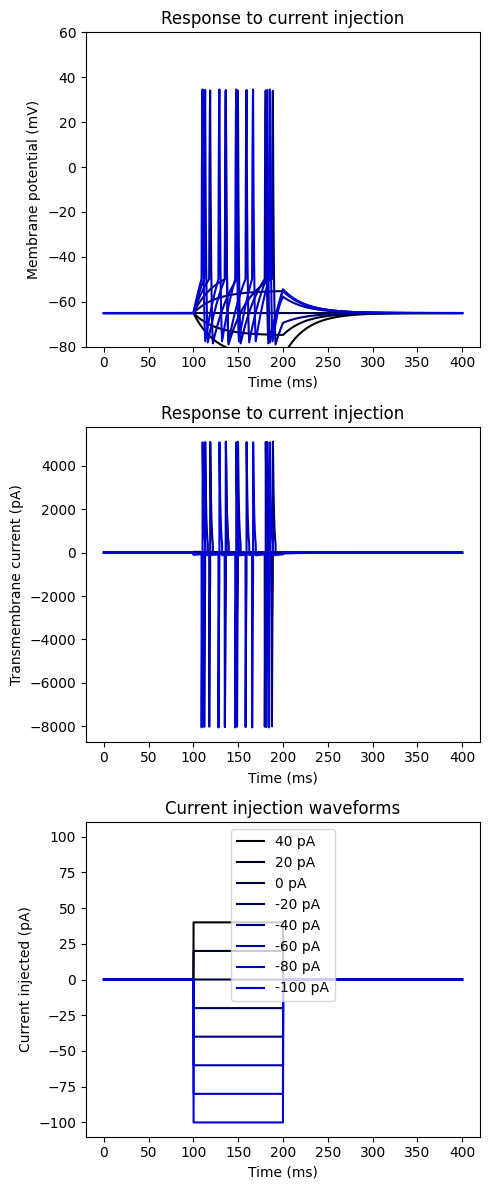

In [115]:
fig, ax = plt.subplots(3,1,figsize=(5,12))
for ind, lvl in enumerate(inp_levels):
    ax[0].plot(t_pts, v_m[:,ind], label=str(round(lvl*1e12))+' pA', color=[0,0,ind/inp_levels.size])
    ax[1].plot(t_pts, i_m[:,ind], label=str(round(lvl*1e12))+' pA', color=[0,0,ind/inp_levels.size])
    ax[2].plot(t_pts, inp[:,ind]*1e12, label=str(round(lvl*1e12))+' pA', color=[0,0,ind/inp_levels.size])

ax[0].set_title('Response to current injection')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Membrane potential (mV)')
ax[0].set_ylim((-80, 60))
#ax[0].set_xlim((1000, 1200))
ax[1].set_title('Response to current injection')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Transmembrane current (pA)')
#ax[1].set_xlim((1000, 1200))
#ax[1].set_ylim((-100, 100))
ax[2].set_title('Current injection waveforms')
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Current injected (pA)')
ax[2].set_ylim((-110, 110))

ax[2].legend()
fig.tight_layout()
plt.show()

In [121]:
class Neuron:
    def __init__(self, v_rest=-65, v_thresh=-50, c_m=1, r_m=25, radius=10, dt=0.001):
        self.dt = dt # sec
        self._vrest = v_rest/1000 # mV
        self._vthresh = v_thresh/1000 # mV
        self._cm = c_m * 1e-6 # uF/cm^2
        self._rm = r_m * 1e3 # kOhm*cm^2
        self._radius = radius * 1e-4 # cm

        self._area = 4 * np.pi * self._radius**2 # cm^2
        self._c = self._cm * self._area # F  
        self._gleak = 1 / (self._rm / self._area) # S

        self._vm = self._vrest
        self._im = 0
        self._spk = False
        self._inp = 0

    def get_tau(self):
        return self._cm * self._rm
    
    def set_input(self, inp=0):
        self._inp = inp
    
    def reset_state(self):
        self._vm = self._vrest
        self._im = 0
        self._spk = False
        self._inp = 0
    
    def get_state(self):
        # return membrane potential in mV, membrane current in pA, and spike status
        return self._vm*1e3, self._im*1e12, self._spk
        
    def update(self):
        # solve for transmembrane currents
        self._im = (self._gleak * (self._vm - self._vrest)) + self._inp
        
        # if action potential threshold is crossed, inject current to simulate action potential
        if (self._vm > self._vthresh) & (self._spk == False):
            self._im = self._im - 1e-9
            self._spk = True
        elif self._spk == True: # following spike, reset membrane potential to simulate refractory period
            self._spk = False
            self._vm = self._vrest - 0.01
            return
        
        # update membrane potential
        self._vm = self._vm + -(self._im / self._c) * self.dt
        
    def run_step(self, inp=0):
        self.set_input(inp)
        self.update()
        return self.get_state()

In [143]:
sim_time = 0.4 # sec
dt = 0.001 # sec
step_num = int(sim_time / dt)
t = (np.arange(0, step_num) * dt) * 1000 # ms
inp_levels = -np.arange(-1e-11, 4e-11, 0.2e-11)
lvl_num = inp_levels.size
inp = np.zeros((step_num, lvl_num))
inp[100:200,:] = 1
inp = inp * inp_levels
nrn1 = Neuron()
v_m1 = np.zeros(inp.shape)
i_m1 = np.zeros(inp.shape)
spk1 = np.zeros(inp.shape)
for i in range(inp.shape[1]):
    nrn1.reset_state()
    for t in range(inp.shape[0]):
        v_m1[t,i], i_m1[t,i], spk1[t,i] = nrn1.run_step(inp[t,i])


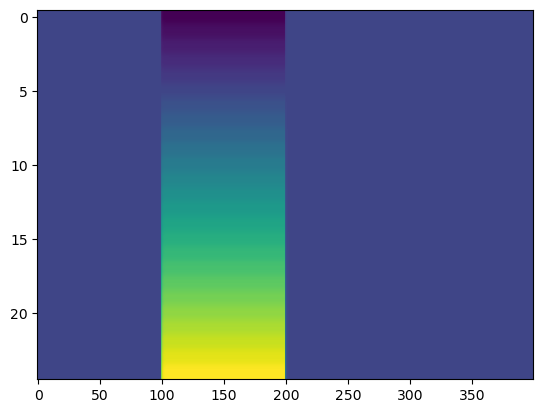

In [144]:
fig, ax = plt.subplots()
ax.imshow(v_m1.T, aspect='auto')
plt.show()

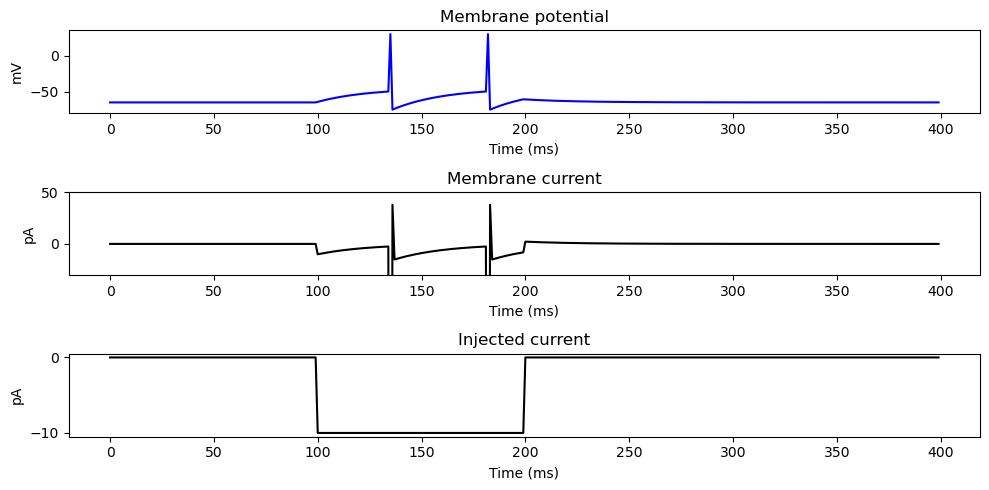

In [119]:
# plot v_m and inp on the same axis with separate y-axes
fig, ax = plt.subplots(3,1,figsize=(10,5))
ax[0].plot(t, v_m1, 'b')
ax[0].set_title('Membrane potential')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('mV')

ax[1].plot(t, i_m1, 'k')
ax[1].set_ylim((-30, 50))
ax[1].set_title('Membrane current')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('pA')

ax[2].plot(t, inp*10**12, 'k')
ax[2].set_title('Injected current')
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('pA')

fig.tight_layout()